In [53]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


"""
An `in-folder` reduction script CGM^2 Multi-Object Spectra

Note: You should really be running the prepare file to get this into the correct format...
"""

__author__ = "Matthew Wilde <mwilde@uw.edu>"
__version__ = "March, 2018"

try:
    from pyraf import iraf

except ImportError:
    raise ImportError("No pyraf module -- did you forget to do `source activate geminiconda`?")


import os
import copy
from pyraf.iraf import gemini, gmos, gemtools, onedspec
import numpy as np
from astropy.io import fits
from astropy.table import Table
import glob
import matplotlib.pyplot as plt
% matplotlib inline

path = os.path.abspath('.')

# Need to make this more general for LP,Rollup
cent_waves = [600.0, 610.0]

# Set colormap for plotting
cm = plt.get_cmap('Greys')

flatName = 'MC' + 'gcalFlat' 
combName = 'MC' + 'gcalFlat' + 'Comb'
biasName = 'MCbiasFull.fits'


def observation_summary(filenames, additional_headers=None):
    """
    Create a table to serve as an observing summary.
    """
    
    # List the headers we want to extract
    headers = ["INSTRUME", "OBJECT", "OBSTYPE", "MASKNAME", "OBSCLASS", 
               "CENTWAVE", "GEMPRGID", "OBSID", "CCDBIN", "RAWPIREQ",
               "DATALAB", "UT", "DATE", "TIME-OBS", "GRATING", "EXPOSURE", "DETECTOR", "DATE-OBS"]
    
    if additional_headers is not None:
        headers += additional_headers

    rows = []
    for filename in filenames:
        with fits.open(filename) as image:
            rows.append(dict(zip(headers,
                [image[0].header.get(h, None) for h in headers])))

        # Add the filename.
        rows[-1]["FILENAME"] = filename

    headers.insert(0, "FILENAME")
    #headers.append("TIME")

    return Table(rows=rows, names=headers)

def show_img(img, z1, z2):
    plt.clf()
    ax = plt.gca()
    ax.imshow(img,vmin=z1,vmax=z2,cmap=cm, origin='lower')
    #
    plt.show()



In [45]:
raw_files = glob.glob('*fits')
summary = observation_summary(raw_files)
summary[summary['OBJECT'] != 'Bias']

FILENAME,INSTRUME,OBJECT,OBSTYPE,MASKNAME,OBSCLASS,CENTWAVE,GEMPRGID,OBSID,CCDBIN,RAWPIREQ,DATALAB,UT,DATE,TIME-OBS,GRATING,EXPOSURE,DETECTOR,DATE-OBS
str24,str6,str10,str6,object,object,object,str14,object,object,object,str21,object,str19,object,object,object,object,str10
N20140624S0295.fits,GMOS-N,CuAr,ARC,GN2014AQ001-12,dayCal,600.0,GN-2014A-Q-1,GN-2014A-Q-1-103,None,UNKNOWN,GN-2014A-Q-1-103-001,15:41:09.6,2014-06-24,15:41:47.9,R400+_G5305,20.0,GMOS + e2v DD CCD42-90,2014-06-24
gsN20140624S0222.fits,GMOS-N,GCALflat,FLAT,GN2014AQ001-12,partnerCal,600.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-003,09:51:55.6,2018-03-07T03:24:45,09:52:34.0,R400+_G5305,2.0,GMOS + e2v DD CCD42-90,2014-06-24
N20140624S0221.fits,GMOS-N,J1555+3628,OBJECT,GN2014AQ001-12,science,600.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-002,09:33:41.1,2014-06-24,09:34:19.2,R400+_G5305,1050.0,GMOS + e2v DD CCD42-90,2014-06-24
MCgcalFlatComb610.0.fits,GMOS-N,GCALflat,FLAT,GN2014AQ001-12,partnerCal,610.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-004,09:52:46.1,2018-03-07T03:27:07,09:53:24.5,R400+_G5305,2.0,GMOS + e2v DD CCD42-90,2014-06-24
N20140624S0220.fits,GMOS-N,J1555+3628,OBJECT,GN2014AQ001-12,science,600.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-001,09:15:42.1,2014-06-24,09:16:20.4,R400+_G5305,1050.0,GMOS + e2v DD CCD42-90,2014-06-24
MCgcalFlatComb600.0.fits,GMOS-N,GCALflat,FLAT,GN2014AQ001-12,partnerCal,600.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-003,09:51:55.6,2018-03-07T03:24:45,09:52:34.0,R400+_G5305,2.0,GMOS + e2v DD CCD42-90,2014-06-24
gsN20140624S0223.fits,GMOS-N,GCALflat,FLAT,GN2014AQ001-12,partnerCal,610.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-004,09:52:46.1,2018-03-07T03:27:07,09:53:24.5,R400+_G5305,2.0,GMOS + e2v DD CCD42-90,2014-06-24
N20140624S0225.fits,GMOS-N,J1555+3628,OBJECT,GN2014AQ001-12,science,610.0,GN-2014A-Q-1,GN-2014A-Q-1-102,None,YES,GN-2014A-Q-1-102-006,10:11:32.6,2014-06-24,10:12:10.9,R400+_G5305,1050.0,GMOS + e2v DD CCD42-90,2014-06-24
GN2014AQ001-12.fits,GMOS-N,J1555+3628,MASK,None,None,None,GN-2014A-Q-1,None,None,None,GN2014AQ001-12,None,2014-05-17T02:09:27,None,None,None,None,2014-05-16


In [18]:
print ("### Begin Processing GMOS/MOS Spectra ###")
print (' ')
print('IN FOLDER: ',os.path.abspath('.'),path)
print (' ')
print ("=== Creating FLAT MasterCals ===")
if not os.path.exists(flatName+'.fits'):
    print (" -- Creating GCAL Spectral Flat-Field MasterCals --")
    print ("  -Full Flat (GCAL) normalization, non-interactive-")

    # Set the task parameters.
    gmos.gireduce.unlearn()
    gmos.gsflat.unlearn()
    flatFlags = {'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_dark':'no',
                'fl_fixpix':'no','fl_oversize':'no','fl_vardq':'yes','fl_fulldq':'yes',
                'fl_inter':'no','fl_detec':'yes',
                'function':'spline3','order':'8',
                'logfile':'gsflatLog.txt','verbose':'no'
    }


    # TODO: make a case for LP data
    flatFlags.update({'fl_keep':'yes','fl_usegrad':'yes','fl_detec':'no',
                     'fl_seprows':'no','order':53})

    # flat type
    ft = 'gcalFlat'
    # loop over central wavelengths
    flatName=''
    combName=''
    for cw in cent_waves:
        flatName = 'MC' + ft + str(cw)
        combName = 'MC' + ft + 'Comb' + str(cw)
        flats = summary[(summary['OBSTYPE'] == 'FLAT') & (summary['CENTWAVE'] == cw)]['FILENAME']
        flatFull = [os.path.basename(f) for f in flats]
        gmos.gsflat (','.join(str(x) for x in flatFull), flatName, 
                     bias='MCbiasFull.fits', combflat=combName, **flatFlags)
else:
    print(flatName,'already exists')

### Begin Processing GMOS/MOS Spectra ###
 
('IN FOLDER: ', '/Users/mwilde/Dropbox/COS-Gemini/gmosredux', '/Users/mwilde/Dropbox/COS-Gemini/gmosredux')
 
=== Creating FLAT MasterCals ===
 -- Creating GCAL Spectral Flat-Field MasterCals --
  -Full Flat (GCAL) normalization, non-interactive-
WARNING - GIREDUCE: Bad Pixel Mask filename is an empty string
                    Only saturated pixels will be flagged
WARNING - GSFLAT: only one image.
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Usin

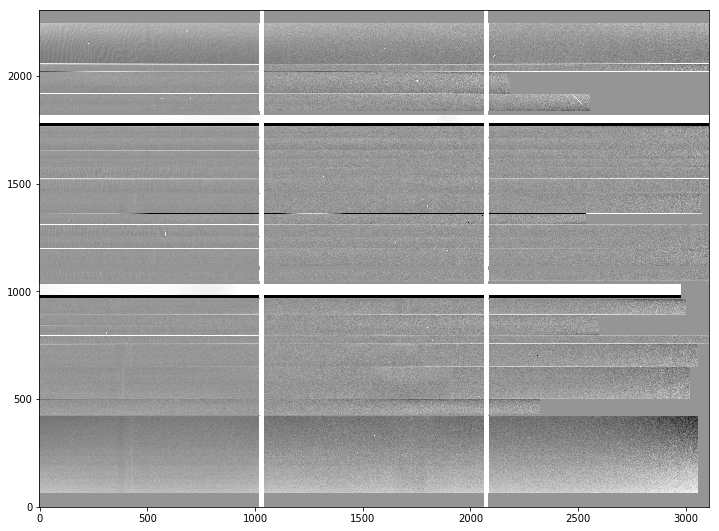

In [49]:
idx = 2 
dfile = flatName+'.fits'
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data, 0.8, 1.2)

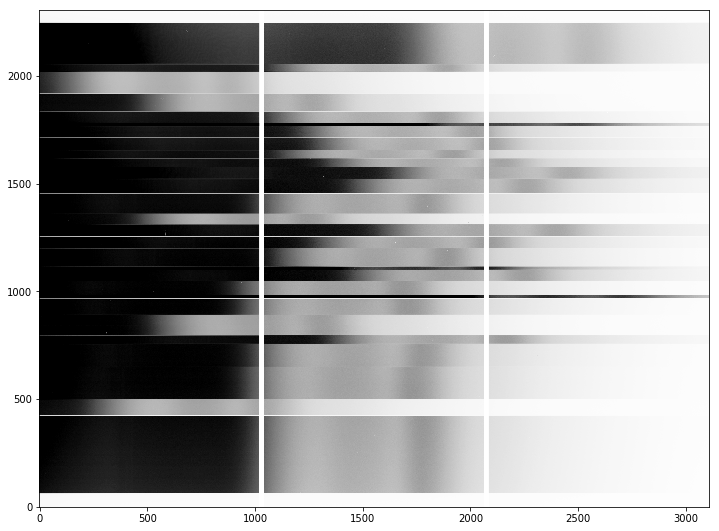

In [50]:
idx = 2 
dfile = 'MC' + ft + 'Comb' + str(cw)+'.fits'
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data, 0.8, 70000)

In [54]:
print ("=== Processing Science Files ===")
print (" -- Performing Basic Processing --")

# Use primarily the default task parameters.
gmos.gsreduce.unlearn()
sciFlags = {
    'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
    'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
    'fl_gsappwave':'yes','fl_oversize':'no',
    'fl_vardq':'yes','fl_fulldq':'yes',
    'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
}
arcFlags = copy.deepcopy(sciFlags)
arcFlags.update({'fl_flat':'no','fl_vardq':'no','fl_fulldq':'no'})


gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':6,'nsum':50,
    'function':'chebyshev','order':7,
    'fl_inter':'no','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':2})


# Set CR task parameters.
# NOTE: Turned on crreject. Does a good job of getting rid of cosmic rays
gemtools.gemcombine.unlearn()
sciCombFlags = {
    'combine':'average','reject':'crreject',
    'fl_vardq':'yes','fl_dqprop':'yes',
    'logfile':'gemcombineLog.txt','verbose':'no'
}

gmos.gstransform.unlearn()
transFlags = {
    'fl_vardq':'yes','interptype':'linear','fl_flux':'yes',
    'logfile':'gstransformLog.txt','verbose':'no'
}
transFlags.update({'fl_vardq':'yes'})

print ('  - MOS Science and Arc exposures -')
prefix = 'gs' # 
ft = 'gcalFlat' # flat type
for i,cw in enumerate(cent_waves):
    flatName = 'MC' + ft + str(cw)
    gradName = 'MC' + ft + 'Comb' + str(cw)
    
    ################### ARCS: Reduce and find wavelengths ###############################
    # Arcs
    # arcFull = fs.fileListQuery(dbFile, fs.createQuery('arc', qdf), qdf)
    arcs = summary[(summary['OBSTYPE'] == 'ARC') & (summary['CENTWAVE'] == cw)]['FILENAME']
    arcFull = [os.path.basename(f) for f in arcs]
    reduced_arcs = [prefix + str(x) for x in arcFull]
    if not os.path.exists(reduced_arcs[0]):
        gmos.gsreduce (','.join(str(x) for x in arcFull), bias=biasName, gradimage=gradName, **arcFlags)
        gmos.gswavelength(','.join(prefix+str(x) for x in arcFull), **waveFlags)
    
    ################### SCI: Reduce and find wavelengths ###############################
    # Science Images
    # sciFull = fs.fileListQuery(dbFile, fs.createQuery('sciSpec', qdf), qdf)
    sci = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['FILENAME']
    sciFull = [os.path.basename(f) for f in sci]
    reduced_imgs = [prefix + str(x) + '.fits' for x in sciFull]
    # reduce the SCIENCE images
    if not os.path.exists(reduced_imgs[0]):
        gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName, gradimage=gradName, **sciFlags)
    
    i = i + 1
    outFile = "cr_sci"+str(i)+"w_auto_slit.fits"
    # combine the 2 exposures at the same central wavelength
    gemtools.gemcombine (','.join(prefix+str(x) for x in sciFull), outFile,
                           **sciCombFlags)
    
    # get the quasar name convention right: quasar+mask+centwave
    quasar_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
    maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
    outFile2 = quasar_name+'_m'+maskname+'_'+str(cw)[:-2]
    outFile2 = outFile2.replace('+','_')
    
    # transform the sci images
    gmos.gstransform (outFile, wavtraname='gs'+arcFull[0], outimages=outFile2,
                      **transFlags)

=== Processing Science Files ===
 -- Performing Basic Processing --
  - MOS Science and Arc exposures -
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WARNING - GSCUT: Slitlength from gradimage more than 3 pixels different from MDF info
                 Using lower edge + MDF info to get upper edge
WA

WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.
WARNING - GEMCOMBINE: five or less images to combine.


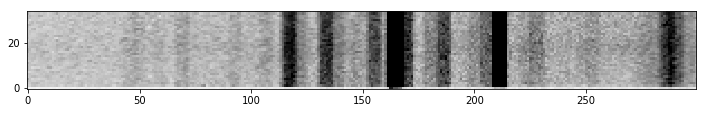

In [65]:
idx = 1
dfile = 'J1555_3628_m12_600.fits'
hdulist = fits.open(dfile)
data = hdulist['sci',idx].data
header = hdulist['sci',idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data[:,1500:1800], 0.8, 100)
